In [51]:
%pip install joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# from sklearn.externals import joblib
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [53]:
# #--------------------
# # tunable-parameters
# #--------------------
# num_trees = 100
# test_size = 0.10
# seed      = 9
# train_path = "dataset/train"
# test_path  = "dataset/test"
# h5_data    = 'output/data.h5'
# h5_labels  = 'output/labels.h5'
# scoring    = "accuracy"

# # get the training labels
# train_labels = os.listdir(train_path)

# # sort the training labels
# train_labels.sort()

# if not os.path.exists(test_path):
#     os.makedirs(test_path)

# # create all the machine learning models
# models = []
# models.append(('LR', LogisticRegression(random_state=seed)))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier(random_state=seed)))
# models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC(random_state=seed)))

# # variables to hold the results and names
# results = []
# names   = []

# # import the feature vector and trained labels
# h5f_data  = h5py.File(h5_data, 'r')
# h5f_label = h5py.File(h5_labels, 'r')

# global_features_string = h5f_data['dataset_1']
# global_labels_string   = h5f_label['dataset_1']

# global_features = np.array(global_features_string)
# global_labels   = np.array(global_labels_string)

# h5f_data.close()
# h5f_label.close()

# # verify the shape of the feature vector and labels
# print("[STATUS] features shape: {}".format(global_features.shape))
# print("[STATUS] labels shape: {}".format(global_labels.shape))

# print("[STATUS] training started...")

# # split the training and testing data
# (trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
#                                                                                           np.array(global_labels),
#                                                                                           test_size=test_size,
#                                                                                           random_state=seed)

# print("[STATUS] splitted train and test data...")
# print("Train data  : {}".format(trainDataGlobal.shape))
# print("Test data   : {}".format(testDataGlobal.shape))
# print("Train labels: {}".format(trainLabelsGlobal.shape))
# print("Test labels : {}".format(testLabelsGlobal.shape))

# # 10-fold cross validation
# for name, model in models:
#     kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
#     cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

# # boxplot algorithm comparison
# fig = pyplot.figure()
# fig.suptitle('Machine Learning algorithm comparison')
# ax = fig.add_subplot(111)
# pyplot.boxplot(results)
# ax.set_xticklabels(names)
# pyplot.show()

In [54]:
# Tunable parameters
num_trees = 100
test_size = 0.10
seed = 9
train_path = "dataset/train"
test_path = "dataset/test"
h5_data = 'output/data.h5'
h5_labels = 'output/labels.h5'
scoring = "accuracy"

In [55]:
# Get the training labels
train_labels = os.listdir(train_path)
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

In [56]:
# Create machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

In [57]:
# Variables to hold the results and names
results = []
names = []

# Import the feature vector and trained labels
h5f_data = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [58]:
# Verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (156, 532)
[STATUS] labels shape: (156,)
[STATUS] training started...


In [59]:
# Split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(
    np.array(global_features),
    np.array(global_labels),
    test_size=test_size,
    random_state=seed
)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (140, 532)
Test data   : (16, 532)
Train labels: (140,)
Test labels : (16,)


LR: 0.978571 (0.032733)
Confusion Matrix for LR:
[[ 5  0]
 [ 1 10]]


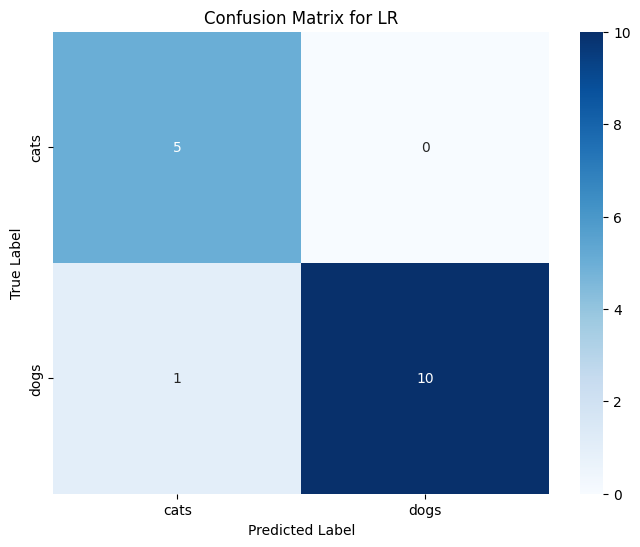

LDA: 0.835714 (0.064286)
Confusion Matrix for LDA:
[[3 2]
 [2 9]]


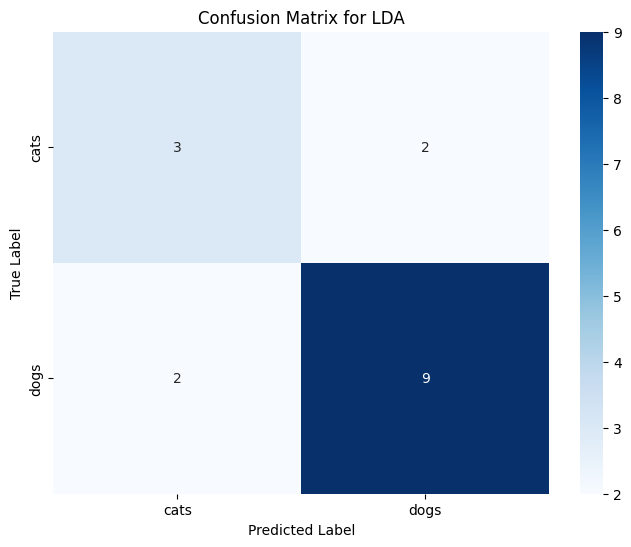

KNN: 0.907143 (0.084817)
Confusion Matrix for KNN:
[[ 5  0]
 [ 1 10]]


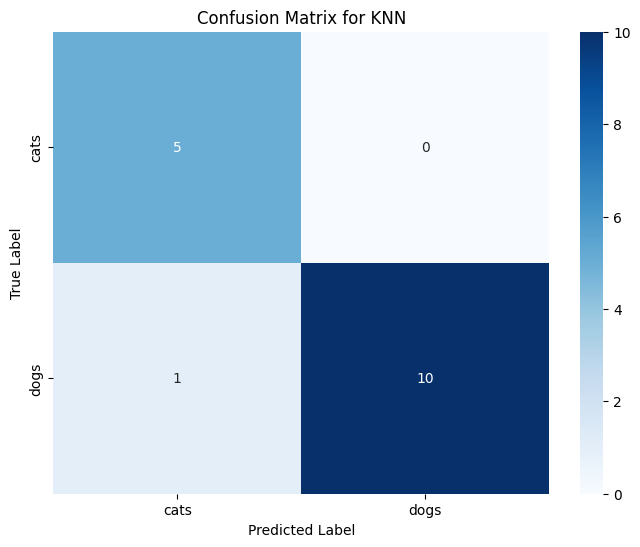

CART: 0.950000 (0.071785)
Confusion Matrix for CART:
[[ 5  0]
 [ 1 10]]


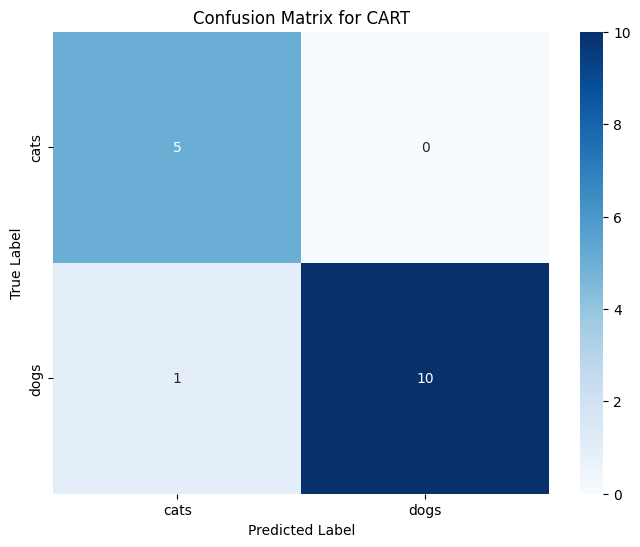

RF: 0.985714 (0.028571)
Confusion Matrix for RF:
[[ 5  0]
 [ 1 10]]


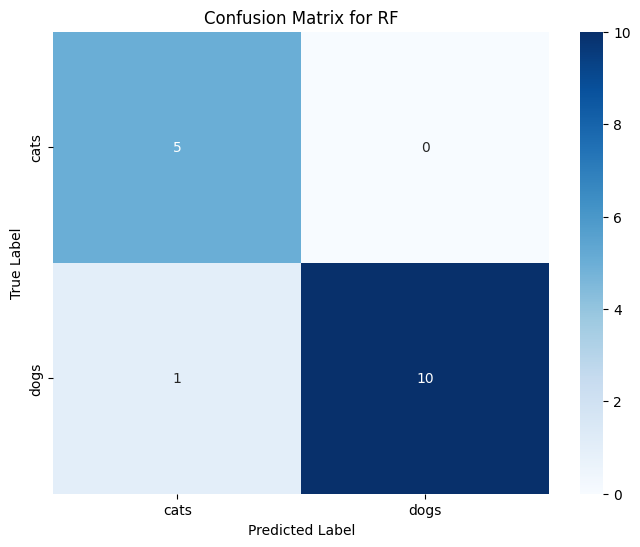

NB: 0.950000 (0.055787)
Confusion Matrix for NB:
[[ 5  0]
 [ 1 10]]


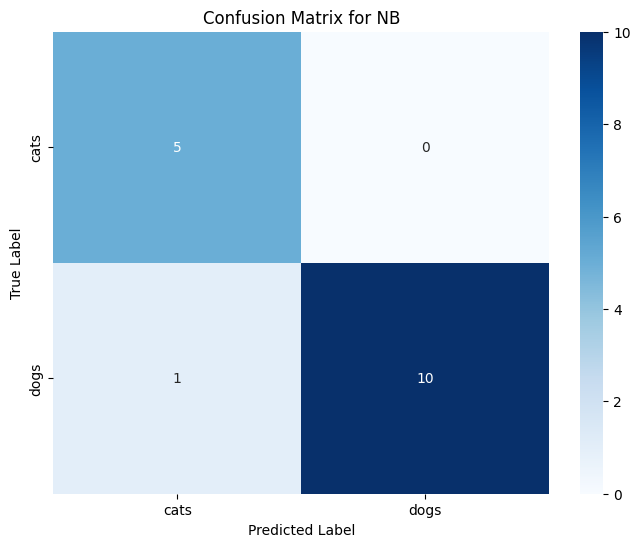

SVM: 0.971429 (0.034993)
Confusion Matrix for SVM:
[[ 5  0]
 [ 1 10]]


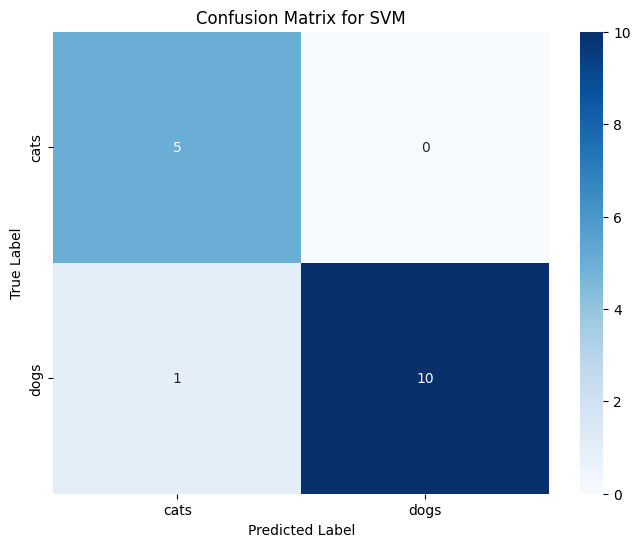

In [60]:
# 10-fold cross-validation
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    # Train the model on the full training set
    model.fit(trainDataGlobal, trainLabelsGlobal)

    # Predict on the test set
    predictions = model.predict(testDataGlobal)

    # Calculate and display the confusion matrix
    cm = confusion_matrix(testLabelsGlobal, predictions)
    print(f"Confusion Matrix for {name}:\n{cm}")

    # Visualize confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_labels, yticklabels=train_labels)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [61]:
# Print overall accuracy
accuracy = accuracy_score(testLabelsGlobal, predictions)
print(f"Overall Accuracy: {accuracy}")

Overall Accuracy: 0.9375


In [62]:
from myglobal import fixed_size
from myglobal import fd_hu_moments
from myglobal import fd_haralick
from myglobal import fd_histogram

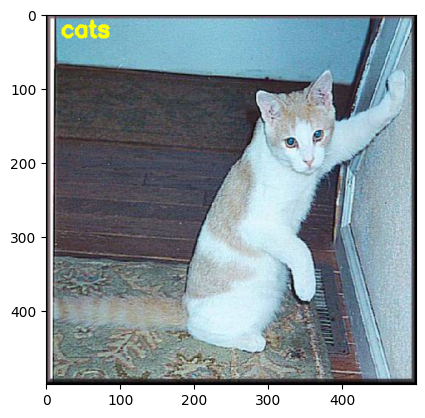

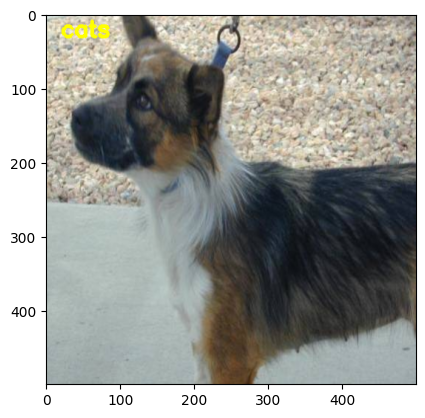

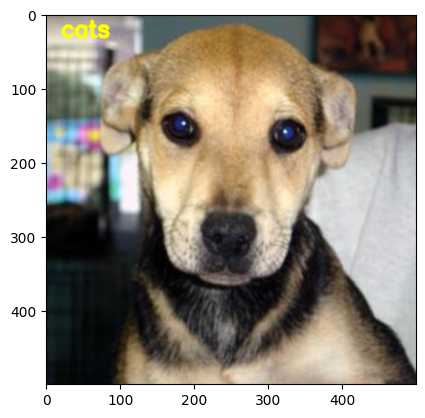

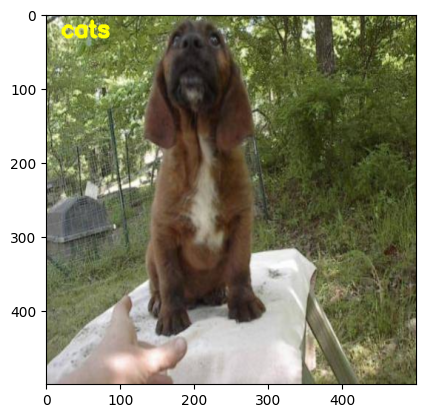

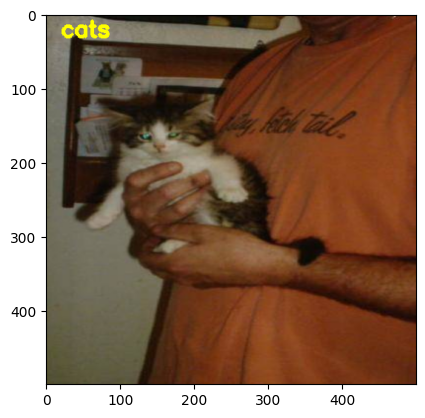

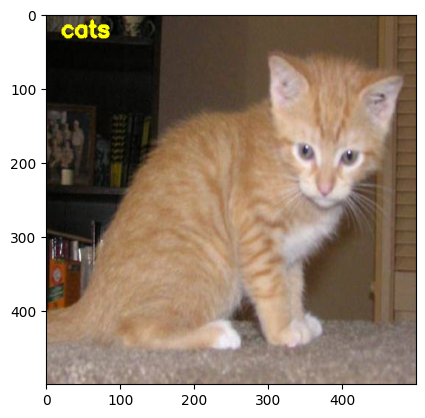

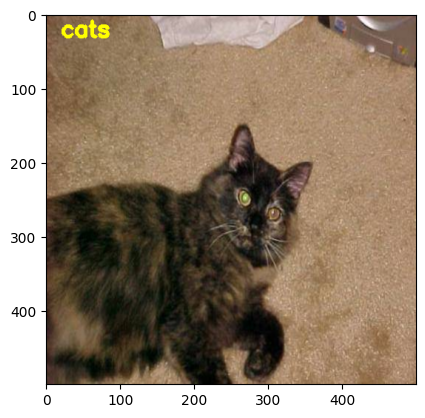

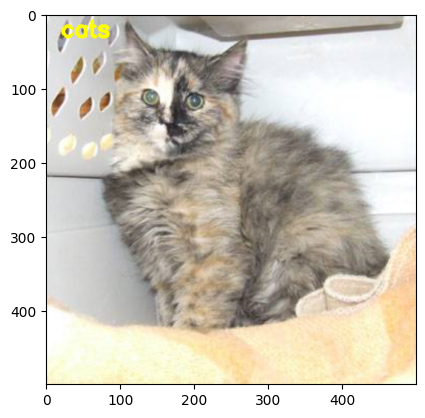

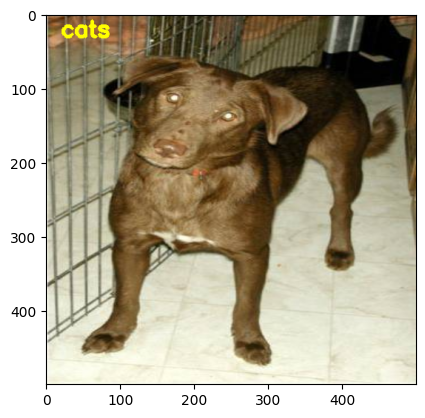

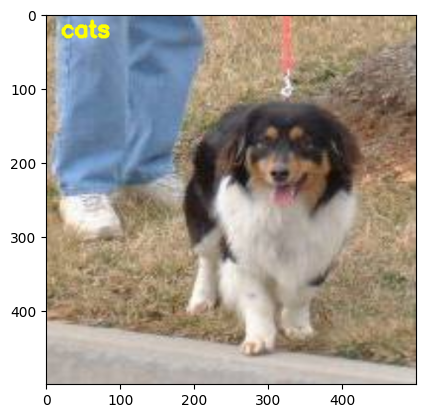

In [63]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)
    # image = cv2.imread(dataset/)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # scale features in the range (0-1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = scaler.fit_transform(global_feature.reshape(-1, 1))

    # predict label of test image
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()